# Sentinel 1 and 2

The aim of this notebook is to guide you how to get Sentinel data using Sentinelhub and eo-learn. Price for subscription is described there https://www.sentinel-hub.com/pricing/.

The workflow for agriculture purposes is as follows :

1) Read shapefile that represent you field (boundaries or microplots)

2) Extract Sentinel-2 data and compute averaged NDVI time series to get a summary of the season vegetation dynamic.

3) Extract Sentinel-1 data and apply multitemporal speckle filtering

## Set your working environment

### Import the packages

In [1]:
import warnings

warnings.filterwarnings("ignore")

import geopandas as gpd
import eocrops
from scipy.signal import savgol_filter
import eocrops.utils.base_functions as utils
import os
import numpy as np
import matplotlib.pyplot as plt
from eolearn.core import FeatureType, AddFeatureTask

from eocrops.inputs import utils_sh as utils_sh
from eocrops.inputs import sentinel1 as sentinel1
from eocrops.inputs import sentinel2 as sentinel2
from eocrops.tasks import cmd_otb as cmd_otb
from eocrops.tasks import preprocessing as preprocessing
from eocrops.tasks import curve_fitting as curve_fitting

from importlib import reload

### Read your vector file (field boundaries)

In [2]:
# read field boundary data
shapefile_input = gpd.read_file("../data/layers/POLYGON.shp")

In [3]:
api = ""
client_id = ""
client_secret = ""


config = utils_sh.config_sentinelhub_cred(api, client_id, client_secret)
# Provide here your planet API key
config.planet_key = ""

In [4]:
time_period = ("2020-02-15", "2020-08-15")
kwargs = dict(polygon=shapefile_input, time_stamp=time_period, config=config)

## Extract S2 data

In [7]:
warnings.filterwarnings("ignore")
patch = sentinel2.workflow_instructions_S2L2A(
    **kwargs,
    path_out=None,  # you can specify here a path to save the EOPatch object
    coverage_predicate=0.5,
    interpolation={"interpolate": True}
)  # you can add period_length in the dictionary to resample

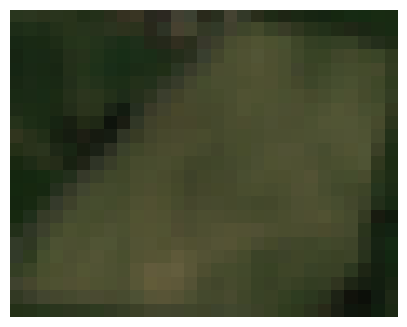

In [10]:
# RGB
plt.figure(figsize=(5, 5))
plt.imshow(
    np.clip(patch.data["BANDS-S2-L2A"][4][..., [2, 1, 0]] * 2.5, 0, 1), vmin=0, vmax=1
)
plt.axis(False)
plt.show()

In [9]:
patch

EOPatch(
  data={
    BANDS-S2-L2A: numpy.ndarray(shape=(21, 23, 29, 10), dtype=float64)
    CCC: numpy.ndarray(shape=(21, 23, 29, 1), dtype=float64)
    CCW: numpy.ndarray(shape=(21, 23, 29, 1), dtype=float64)
    CW: numpy.ndarray(shape=(21, 23, 29, 1), dtype=float64)
    Cab: numpy.ndarray(shape=(21, 23, 29, 1), dtype=float64)
    ECNorm: numpy.ndarray(shape=(21, 23, 29, 1), dtype=float64)
    GNDVI: numpy.ndarray(shape=(21, 23, 29, 1), dtype=float64)
    LAI: numpy.ndarray(shape=(21, 23, 29, 1), dtype=float64)
    NDVI: numpy.ndarray(shape=(21, 23, 29, 1), dtype=float64)
    NDVIre: numpy.ndarray(shape=(21, 23, 29, 1), dtype=float64)
    NDWI: numpy.ndarray(shape=(21, 23, 29, 1), dtype=float64)
    fapar: numpy.ndarray(shape=(21, 23, 29, 1), dtype=float64)
    fcover: numpy.ndarray(shape=(21, 23, 29, 1), dtype=float64)
  }
  mask={
    IS_DATA: numpy.ndarray(shape=(21, 23, 29, 1), dtype=int64)
    VALID_DATA: numpy.ndarray(shape=(21, 23, 29, 1), dtype=bool)
  }
  scalar={
    COVER

In [11]:
masking = preprocessing.MaskPixels(["NDVI", "LAI"])
patch = masking.execute(patch, erosion=1)

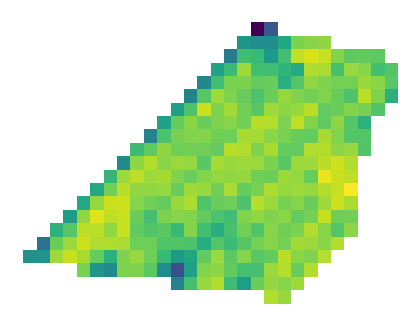

In [12]:
# NDVI
plt.figure(figsize=(5, 5))
plt.imshow(patch.data["NDVI"][10,].squeeze())
plt.axis(False)
plt.show()

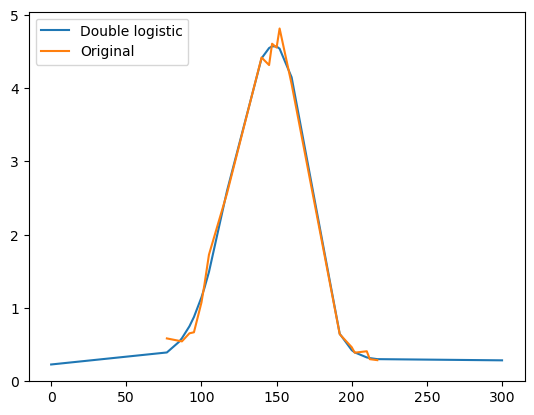

In [13]:
# LAI Time Series from masked field
variable = "LAI"
from importlib import reload
curve_fitting = reload(curve_fitting)
# Subset the time series between doy 30 and 260 => useful for double logistic smoothing
curve_fit = curve_fitting.DoublyLogistic(range_doy=(0, 300))

doy, ts_mean = curve_fit.get_time_series_profile(
    patch, feature=variable, feature_mask="MASK"
)
doy_dl, fitted = curve_fit.execute(patch, feature=variable, feature_mask="MASK")

plt.plot(doy_dl, fitted, label="Double logistic")
plt.plot(doy, ts_mean, label="Original")
plt.legend(loc="upper left")
plt.show()

In [14]:
# Parameters from doubly logistic
# α1 is seasonal minimum greenness
# α2 is the seasonal amplitude
# α3 controls the green-up rate
# α4 is the green-up inflection point
# α5 controls the mid-growing season greenness trajectory.

curve_fit.params[2:]

array([ -4.9830466 , -24.63645053,   0.39373442, -37.43317387,
         0.57326097])

In [15]:
# Peak of the season is at 31/05
time_argmax = np.nanargmax(ts_mean)
patch.timestamp[time_argmax]

datetime.datetime(2020, 5, 31, 11, 17, 40)

In [16]:
# If you would like to save the data in .tif format (e.g. NDVI on the first date)
from eolearn.io import ExportToTiffTask

index_time = 0
date = str(patch.timestamp[index_time]).split(" ")[0]

export = ExportToTiffTask(
    feature=(FeatureType.DATA, "NDVI"),
    folder=os.path.join("your_path_" + date),
    band_indices=[0],
    date_indices=[index_time],
)
patch = export.execute(patch)

## Extract Sentinel-1 data 

In [5]:
s1_eopatch = sentinel1.workflow_instructions_S1IW(
    **kwargs, speckle_lee_window=3, orbit_direction="ASC", backCoeff="SIGMA0_ELLIPSOID"
)

In [6]:
# Compute Radar Vegetation Index
VV = s1_eopatch.data["BANDS-S1-IW"][..., 0]
VH = s1_eopatch.data["BANDS-S1-IW"][..., 1]
RVI = (4 * VH) / (VH + VV)

In [7]:
# Add the feature to the EOPatch
add_rvi = AddFeatureTask((FeatureType.DATA, "RVI"))
add_rvi.execute(eopatch=s1_eopatch, data=RVI[..., np.newaxis])
masking = preprocessing.MaskPixels(["RVI"])
s1_eopatch = masking.execute(s1_eopatch)

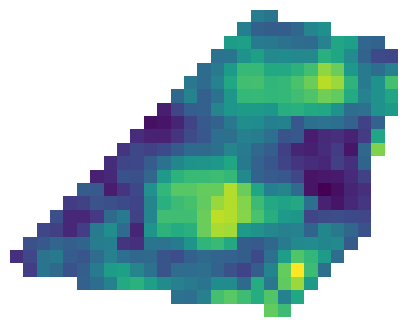

In [8]:
# Display RVI from SIGMA0 without any speckle filtering
s1_eopatch = masking.execute(s1_eopatch)
plt.figure(figsize=(5, 5))
plt.imshow(s1_eopatch.data["RVI"][15,].squeeze())
plt.axis(False)
plt.show()

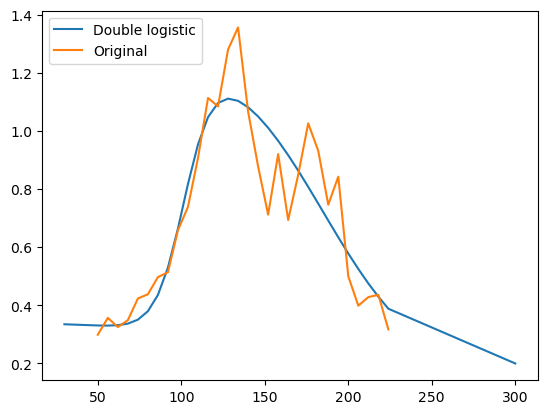

In [9]:
# RVI Time Series from masked field
variable = "RVI"

curve_fit = curve_fitting.DoublyLogistic(range_doy=(30, 300))

doy, ts_mean = curve_fit.get_time_series_profile(
    s1_eopatch, feature=variable, feature_mask="MASK"
)
doy_dl, fitted = curve_fit.execute(s1_eopatch, feature=variable, feature_mask="MASK")

plt.plot(doy_dl, fitted, label="Double logistic")
plt.plot(doy, ts_mean, label="Original")
plt.legend(loc="upper left")
plt.show()

[ 50.  56.  62.  68.  74.  80.  86.  92.  98. 104. 110. 116. 122. 128.
 134. 140. 146. 152. 158. 164. 170. 176. 182. 188. 194. 200. 206. 212.
 218. 224.]


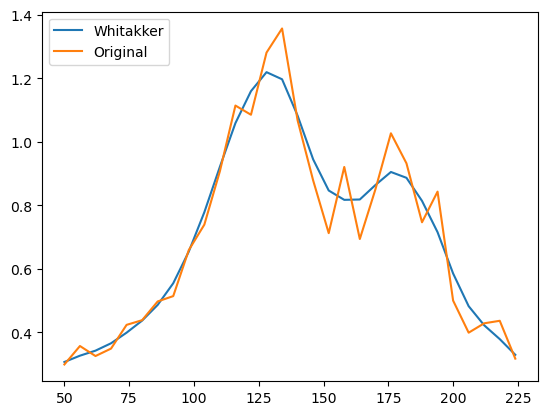

In [15]:
# Whitakker smoothing: you need to have modape installed ! https://github.com/WFP-VAM/modape
# Smooth the signal 

print(doy) #chek if regularly spaced

array_resample_vh_upper = curve_fit.fit_whitakker(ts_mean, degree_smoothing=2, weighted = True) #weighted = True gives more weight to high values

plt.plot(doy, array_resample_vh, label="Whitakker")
plt.plot(doy, ts_mean, label="Original")
plt.legend(loc="upper left")
plt.show()


You can easily download and install OTB https://www.orfeo-toolbox.org/CookBook/Installation.html#linux, which allows you to apply Quegan multitemporal speckle filtering

In [22]:
# Can take around 10 seconds
mutlitemp = cmd_otb.MultitempSpeckleFiltering(
    otb_path="/home/johann/Documents/OTB-8.0.1-Linux64/bin", window=3
)
s1_eopatch = mutlitemp.execute(s1_eopatch)

2023-08-10 10:23:03 (INFO) MultitempFilteringOutcore: Default RAM limit for OTB is 256 MB
2023-08-10 10:23:03 (INFO) MultitempFilteringOutcore: GDAL maximum cache size is 780 MB
2023-08-10 10:23:03 (INFO) MultitempFilteringOutcore: OTB will use at most 8 threads
2023-08-10 10:23:03 (INFO): Loading metadata from official product
2023-08-10 10:23:03 (INFO): Loading metadata from official product
2023-08-10 10:23:03 (INFO): Loading metadata from official product
2023-08-10 10:23:03 (INFO): Loading metadata from official product
2023-08-10 10:23:03 (INFO): Loading metadata from official product
2023-08-10 10:23:03 (INFO): Loading metadata from official product
2023-08-10 10:23:03 (INFO): Loading metadata from official product
2023-08-10 10:23:03 (INFO): Loading metadata from official product
2023-08-10 10:23:03 (INFO): Loading metadata from official product
2023-08-10 10:23:03 (INFO): Loading metadata from official product
2023-08-10 10:23:03 (INFO): Loading metadata from official product


In [23]:
# Compare backscatter values after multitemporal smoothing
VH = s1_eopatch.data["VH_filtered"]
VV = s1_eopatch.data["VV_filtered"]
RVI_smoothed = (4 * VH) / (VH + VV)
# Add the value smoothed to the EOPatch
add_rvi_smoothed = AddFeatureTask((FeatureType.DATA, "RVI_smoothed"))
add_rvi_smoothed.execute(eopatch=s1_eopatch, data=RVI_smoothed)
masking = preprocessing.MaskPixels(["RVI_smoothed"])
s1_eopatch = masking.execute(s1_eopatch)

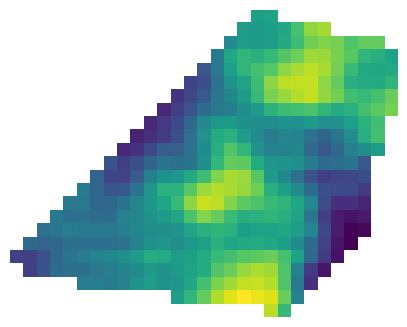

In [24]:
plt.figure(figsize=(5, 5))
plt.imshow(s1_eopatch.data["RVI_smoothed"][15,].squeeze().squeeze())
plt.axis(False)
plt.show()

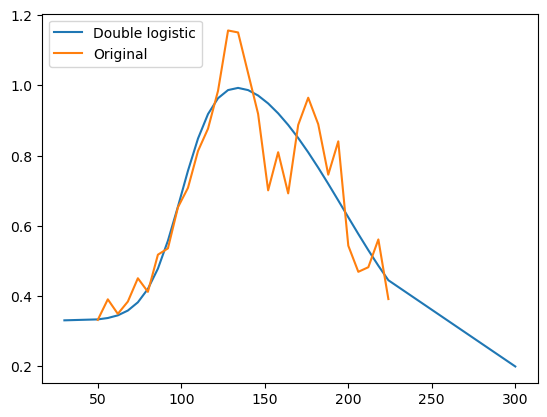

In [25]:
# RVI smoothed Time Series from masked field
variable = "RVI_smoothed"

curve_fit = curve_fitting.DoublyLogistic(range_doy=(30, 300))

doy, ts_mean = curve_fit.get_time_series_profile(
    s1_eopatch, feature=variable, feature_mask="MASK"
)
doy_dl, fitted = curve_fit.execute(s1_eopatch, feature=variable, feature_mask="MASK")

plt.plot(doy_dl, fitted, label="Double logistic")
plt.plot(doy, ts_mean, label="Original")
plt.legend(loc="upper left")
plt.show()